# Data wrangling | Data viz

- Note: URLs automatically update. Each time the code is refreshed/runs, the graph will show a **7-day PASA forecast** starting from the current date.

## A. 7-Day Forecast of Prices and Temperature

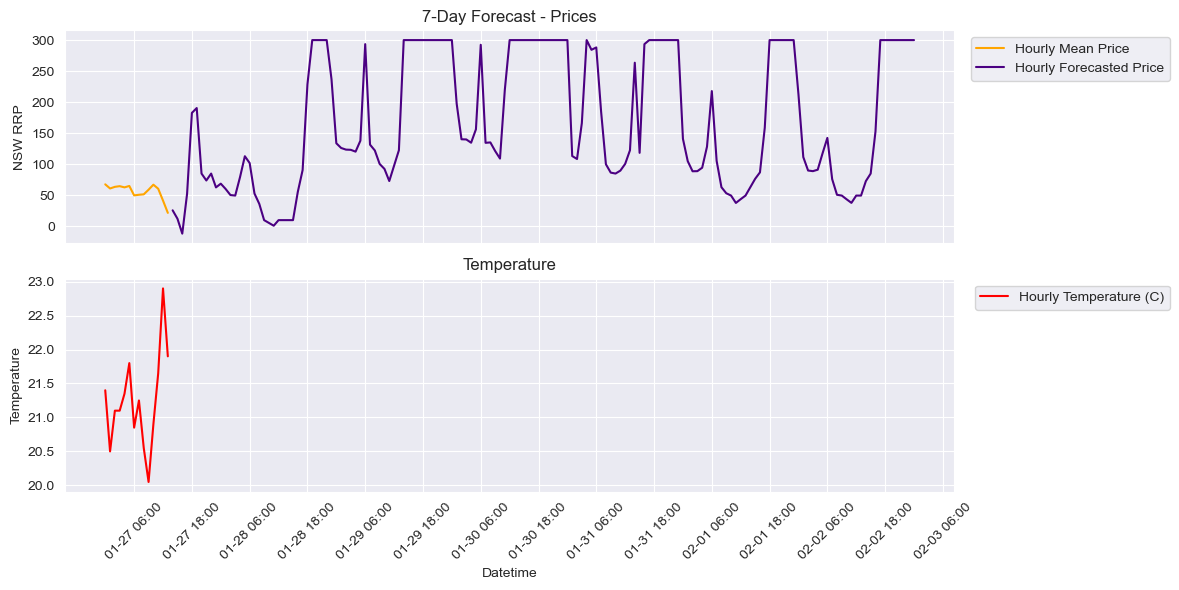

In [6]:
# Removing warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import requests
from datetime import datetime, timedelta

def fetch_data(url):
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    return data

def process_data(df1, df2):
    df1['DateTime.1'] = pd.to_datetime(df1['DateTime.1'])
    df1['DateTime'] = pd.to_datetime(df1['DateTime'])
    df2['DateTime'] = pd.to_datetime(df2['DateTime'])
    df2['DateTime.2'] = pd.to_datetime(df2['DateTime.2'])

    # 1st df: historical data
    historical_df = df1[['DateTime.1', 'NSW1.Price_5min']].copy()
    historical_df = historical_df.resample('H', on='DateTime.1').mean()

    # 2nd df: forecasting data
    forecasting_df = df1[['DateTime', 'NSW1.predispatch 7 day RRP']].copy()
    forecasting_df = forecasting_df.resample('H', on='DateTime').mean()

    price_df = historical_df.merge(forecasting_df, left_index=True, right_index=True)

    price_df['NSW1.predispatch 7 day RRP'] = np.where(price_df['NSW1.Price_5min'].notnull(), np.nan, price_df['NSW1.predispatch 7 day RRP'])

    # Cap the values of the forecasted column at 300
    price_df['NSW1.predispatch 7 day RRP'] = np.clip(price_df['NSW1.predispatch 7 day RRP'], None, 300)

    # 3rd df: historical temperature data
    temperature_df = df2[['DateTime', 'NSW1.Temperature']].copy()
    temperature_df = temperature_df.resample('H', on='DateTime').mean()

    final_df = price_df.merge(temperature_df, left_index=True, right_index=True)
    return final_df

def priceplot(ax, final_df):
    # Plotting the historical and forecast data for prices
    sns.lineplot(x=final_df.index, y=final_df['NSW1.Price_5min'], color='orange', label='Hourly Mean Price', ax=ax)
    sns.lineplot(x=final_df.index, y=final_df['NSW1.predispatch 7 day RRP'], color='indigo', label='Hourly Forecasted Price', ax=ax)
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('NSW RRP')
    ax.set_title('7-Day Forecast - Prices')
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    ax.grid(True)

def tempplot(ax, final_df):
    # Plotting the historical and forecast data for temperature
    sns.lineplot(x=final_df.index, y=final_df['NSW1.Temperature'], color='red', label='Hourly Temperature (C)', ax=ax)
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Temperature')
    ax.set_title('Temperature')
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    ax.grid(True)

def main():
    # Removing warnings
    warnings.filterwarnings("ignore", "is_categorical_dtype")
    warnings.filterwarnings("ignore", "use_inf_as_na")

    # Get the current date
    current_date = datetime.now().strftime('%Y-%m-%d')

    # Generate URLs with the current date
    price_actual_url = f'https://neopoint.com.au/Service/Csv?f=101%20Prices%5CRegion%20RRP%20and%20Latest%20Projection%2030min&from={current_date}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    price_forecast_url = f'https://neopoint.com.au/Service/Csv?f=105%20PASA%20and%20Predispatch%5CWeather%20and%20Demand&from={current_date}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    
    # Read data
    df1 = fetch_data(price_actual_url)
    df2 = fetch_data(price_forecast_url)

    # Process data
    final_df = process_data(df1, df2)

    # Set Seaborn style to "dark"
    sns.set_style("dark")

    # Set figure size and autolayout parameters
    plt.rcParams["figure.figsize"] = [12.00, 6.00]
    plt.rcParams["figure.autolayout"] = True

    # Create subplots with the specified figure size and share the x-axis
    f, axes = plt.subplots(2, 1, sharex=True)

    # Call your functions for each subplot, passing the respective axes and final_df
    priceplot(axes[0], final_df)  
    tempplot(axes[1], final_df)   

    plt.tight_layout()  
    plt.show()

if __name__ == "__main__":
    main()

## B. Recent 7-Day Data on Energy Generated

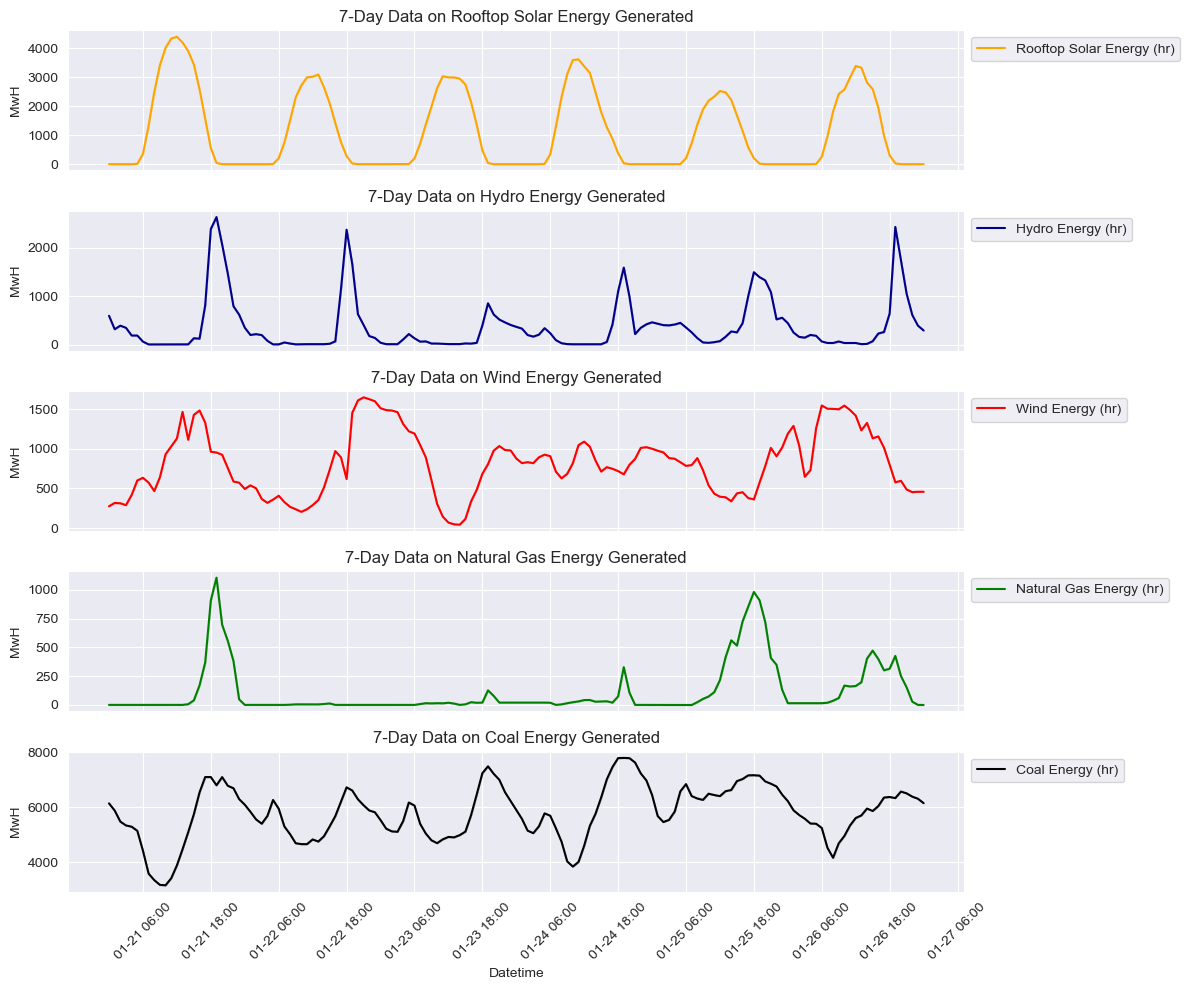

In [12]:
def fetch_data(url):
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    return data

def process_energy_data(df4, df5, df6):
    df4['DateTime'] = pd.to_datetime(df4['DateTime'])
    df5['DateTime'] = pd.to_datetime(df5['DateTime'])
    df6['DateTime'] = pd.to_datetime(df6['DateTime'])

    # 4th df: Generated rooftop solar data
    rooftop_actual = df4[['DateTime', 'Rooftop PV MEASUREMENT']].copy()
    rooftop_actual = rooftop_actual.resample('H', on='DateTime').mean()

    # 5th df: Forecasted rooftop solar data
    rooftop_forecast = df5[['DateTime', 'POWERMEAN']].copy()
    rooftop_forecast = rooftop_forecast.resample('H', on='DateTime').mean()

    rooftop_df = pd.concat([rooftop_actual, rooftop_forecast])

    # 6th df: Other energy sources data
    hydro_df = df6[['DateTime', 'Hydro.Generation']].copy()
    hydro_df = hydro_df.resample('H', on='DateTime').mean()
    wind_df = df6[['DateTime', 'Wind.Generation']].copy()
    wind_df = wind_df.resample('H', on='DateTime').mean()
    gas_df = df6[['DateTime', 'Natural Gas.Generation']].copy()
    gas_df = gas_df.resample('H', on='DateTime').mean()
    coal_df = df6[['DateTime', 'Black Coal.Generation']].copy()
    coal_df = coal_df.resample('H', on='DateTime').mean()


    # Concatenate rooftop, hydro, wind data
    hydrosolar_df = pd.concat([hydro_df, rooftop_df])
    hydrosolarwind_df = pd.concat([hydrosolar_df, wind_df])
    hydrosolarwindcoal_df = pd.concat([hydrosolarwind_df, coal_df])
    final_df = pd.concat([gas_df, hydrosolarwindcoal_df])
    
    return final_df
    
def rooftop_solar(ax, final_df):
    sns.lineplot(x=final_df.index, y=final_df['Rooftop PV MEASUREMENT'], color='orange', label='Rooftop Solar Energy (hr)', ax=ax)
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%a, %m-%d %H:%M') for dt in midpoints], rotation=45, ha='right')       
    ax.set_xlabel('Datetime')
    ax.set_ylabel('MwH')
    ax.set_title('7-Day Data on Rooftop Solar Energy Generated')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)

def hydro(ax, final_df):
    sns.lineplot(x=final_df.index, y=final_df['Hydro.Generation'], color='darkblue', label='Hydro Energy (hr)', ax=ax)
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%a, %m-%d %H:%M') for dt in midpoints], rotation=45, ha='right')       
    ax.set_xlabel('Datetime')
    ax.set_ylabel('MwH')
    ax.set_title('7-Day Data on Hydro Energy Generated')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)

def wind(ax, final_df):
    sns.lineplot(x=final_df.index, y=final_df['Wind.Generation'], color='red', label='Wind Energy (hr)', ax=ax)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('MwH')
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
    ax.set_title('7-Day Data on Wind Energy Generated')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)

def gas(ax, final_df):
    sns.lineplot(x=final_df.index, y=final_df['Natural Gas.Generation'], color='green', label='Natural Gas Energy (hr)', ax=ax)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('MwH')
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
    ax.set_title('7-Day Data on Natural Gas Energy Generated')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)
    
def coal(ax, final_df):
    sns.lineplot(x=final_df.index, y=final_df['Black Coal.Generation'], color='black', label='Coal Energy (hr)', ax=ax)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('MwH')
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
    ax.set_title('7-Day Data on Coal Energy Generated')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)
 

def main():
    # Removing warnings
    warnings.filterwarnings("ignore", "is_categorical_dtype")
    warnings.filterwarnings("ignore", "use_inf_as_na")

    # Get the current date
    current_date = datetime.now().strftime('%Y-%m-%d')
    weekly_data = (datetime.now() - timedelta(days=6)).strftime('%Y-%m-%d')
    
    # Generate URLs with the current date
    rooftopsolar_actual_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRooftop%20PV%20Generation&from={weekly_data}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    rooftopsolar_forecast_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRooftop%20PV%20Forecast&from={current_date}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    energy_source_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRegional%205min%20generation%20by%20fuel&from={weekly_data}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    
    # Read data
    df4 = fetch_data(rooftopsolar_actual_url)
    df5 = fetch_data(rooftopsolar_forecast_url)
    df6 = fetch_data(energy_source_url)

    # Process data
    final_df = process_energy_data(df4, df5, df6)

    # Set Seaborn style to "dark"
    sns.set_style("dark")
    # Set figure size and autolayout parameters
    plt.rcParams["figure.figsize"] = [12.00, 10.00]
    plt.rcParams["figure.autolayout"] = True

    # Filter data up to the current date
    current_date = datetime.now().strftime('%Y-%m-%d')
    final_df = final_df[final_df.index <= current_date]

    # Create subplots with the specified figure size and share the x-axis
    f, axes = plt.subplots(5, 1, sharex=True)

    rooftop_solar(axes[0], final_df)  
    hydro(axes[1], final_df)  
    wind(axes[2], final_df) 
    gas(axes[3], final_df) 
    coal(axes[4], final_df) 

    plt.tight_layout() 
    plt.show()

    
if __name__ == "__main__":
    main()